## Commonsense Knowledge Base Reasoning


# Mohammad Asif Khan
# Matriculation No: 3063566

# Motivation

Ever since the beginning of artificial intelligence common sense reasoning is identified as a key challenge. Ability to use commonsense knowledge can help intelligent systems to capture collection of information that normal humans usually have. For instance, if system knows that restaurants are place for food, then should also know that when X visits restaurant, it is generally X is looking for food. However, such form of reasoning is difficult and challenging because it uses a knowledge which is so actively used in everyday world that it is rarely expressed explicitly. Such reasoning is important for solving various AI tasks: natural language processing, computer vision, planning, reasoning etc.

Due to its richness and wide use in everyday life, McCarthy categorized commonsense into various domains including time and space, causality, approximate or qualitative theories of motion, force, substances, and energy, continuous change and quantities. Such classification enabled researchers to create domain specific knowledge bases of commonsense. Some of the commonly used knowledge bases are: Cyc, ConceptNet for properties, SenticNet for emotions, WordNet for taxonomies and many others. Figure 1 gives an example of some domain and type of knowledge base. 


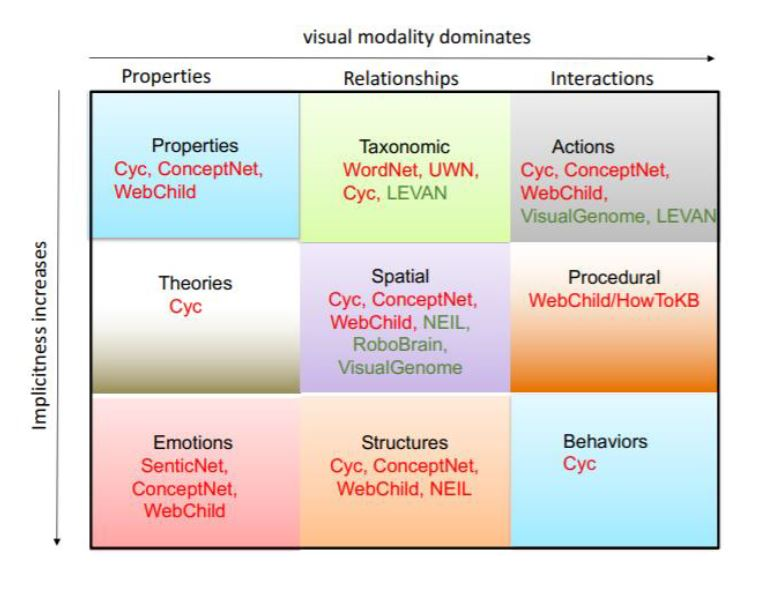

In [1]:
from IPython.display import Image
Image(filename='images/commonsense_type1.JPG', width=300)

In this work we focus on commonsense reasoning for NLP task. We do so by formulating a problem of knowledge completion on ConceptNet. Such a formulation could help in increasing the coverage of knowledge in ConceptNet. Recently a lot of methods in knowledge base completion have been developed which can infer new facts based on existing knowledge. This work implements some such methods and extends them for commonsense knowledge base a.k.a ConceptNet. Doing so helps in learning common sense enriched word embeddings which can be used for different tasks like text classification, sentiment analysis, entity resolution, question answering etc.

# Background

Before beginning with the implementation we will briefly discuss some basic concepts used in this work.
ConceptNet is a large semantic knowledge base of commonsense developed by the Open Mind Common Sense (OMCS) project at MIT. ConceptNet stores knowledge using concepts and relations between them. Technically each knowledge fact is represented as a triples consisting of left term, a relation and a right term. Unlike other KBs where terms are entities represented by unique token, in ConceptNet terms are concepts represented as an arbitrary phrase of noun or verb. The relation are from fixed set of size 34. For details on creation and coverage of ConceptNet readers are recommended to follow [2]. A figure below shows an example of few triples in ConceptNet.

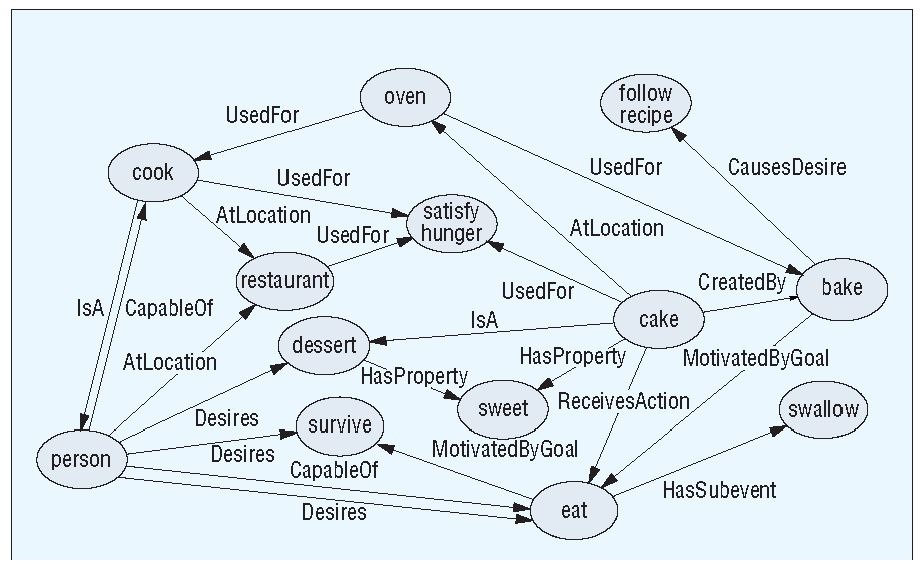

In [2]:
Image(filename='images/conceptNet.JPG', width=300)

# Knowledge Base Completion as a Triple Classification

We consider facts in KB as postive examples and under Closed World Assumption any unknown triple as a negative. Thus reducing it to standard classification problem. Below figure is a small demonstration.

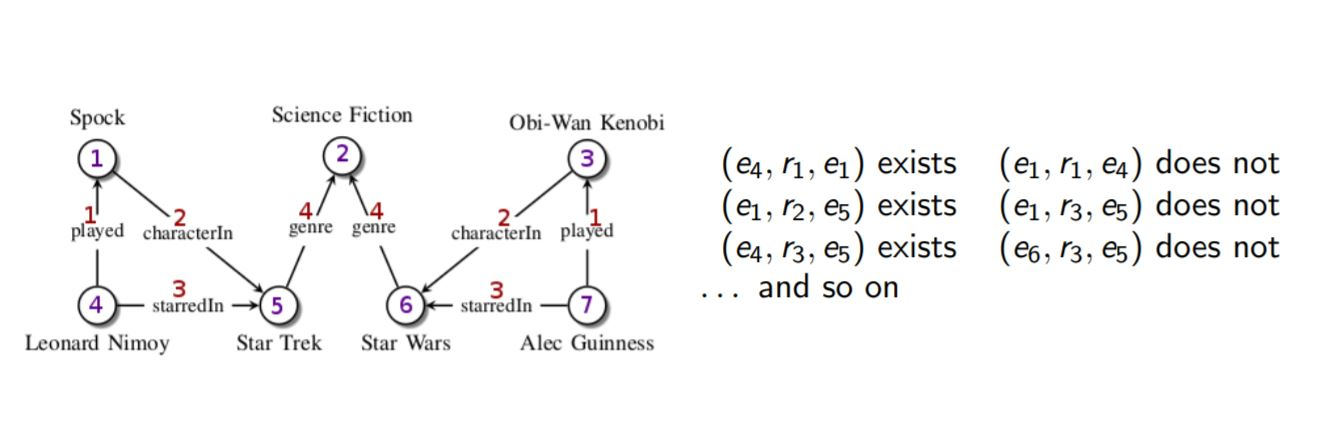

In [3]:
from IPython.display import Image
Image(filename='images/triple_class.JPG')

# Project Outline

We present our implementation and results in following steps.

1. Data Preparation
2. Pretraining 
3. Neural Network Models
4. Training and Validation Setup
5. Results
6. Conclusion

In [4]:
# Import Libraries
import numpy as np
import random as random
import torch
import pdb
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import os
import multiprocessing
import sys
from argparse import ArgumentParser, FileType, ArgumentDefaultsHelpFormatter
import numpy as np
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.utils import shuffle
from torch.autograd import Variable
from torch.nn import functional as F


# Data Preparation

We implemented a class to read dataset and convert it into padded sequence of tokens to train with NN models.

In [5]:
class preprocess:

    def __init__(self):
        self.train_triples = []
        self.valid_triples = []
        self.test_triples = []
        self.maxlen_s = 0
        self.maxlen_o = 0
        self.word_vec_map = {}
        self.word_id_map = {}
        self.embedding_weights = {}
        self.rel = {}
        self.n_r = 0

    def read_train_triples(self, filename):
        self.train_triples = [line.strip().split('\t') for line in open(filename,'r')]

    def read_valid_triples(self, filename):
        self.valid_triples = [line.strip().split('\t') for line in open(filename,'r')]

    def read_test_triples(self, filename):
        self.test_triples = [line.strip().split('\t') for line in open(filename,'r')]

    def read_relations(self, filename):
        self.rel ={line.strip():key+1 for key,line in enumerate(open(filename,'r'))}
        self.rel['UUUNKKK'] = 0
        self.n_rel = len(self.rel)

    def embedding_matrix(self):
        matrix = np.zeros((len(self.embedding_weights), self.embedding_dim))
        for key,value in self.embedding_weights.items():
            matrix[key,:] = value
        return matrix

    def load_embedding(self, filename):
        with open(filename,'r') as f:
            for i,line in enumerate(f):
                pair = line.split()
                word = pair[0]
                embedding = np.array(pair[1:], dtype='float32')
                self.word_vec_map[word] = embedding
                self.word_id_map[word] = i+1
            self.embedding_dim = len(embedding)

    def pretrained_embeddings(self, filename='embeddings.txt'):
        self.load_embedding(filename)
        for word, id_ in self.word_id_map.items():
            self.embedding_weights[id_] = self.word_vec_map[word]
        self.word_id_map['PAD'] = 0
        self.embedding_weights[self.word_id_map['PAD']] = np.zeros(self.embedding_dim)

    def sentence2idx(self, sentence):
        return [self.word_id_map[word] if word in self.word_id_map else self.word_id_map['UUUNKKK'] for word in sentence]

    def rel2idx(self, rel):
        return self.rel[rel.lower()] if rel.lower() in self.rel.keys() else self.rel['UUUNKKK'] 

    def	triple_to_index(self, triples, dev=False):
        triple2idx = []
        for triple in triples:
            if dev:
                p, s, o, label = triple[0], triple[1].split(' '), triple[2].split(' '), int(triple[3])
                triple2idx.append([self.rel2idx(p),self.sentence2idx(s),self.sentence2idx(o), label])
            else:
                p, s, o = triple[0], triple[1].split(' '), triple[2].split(' ')
                triple2idx.append([self.rel2idx(p),self.sentence2idx(s),self.sentence2idx(o)])
        return triple2idx

    def get_max_len(self, tripleidx):
        for triple in tripleidx:
            self.maxlen_s = max(self.maxlen_s, len(triple[1]))
            self.maxlen_o = max(self.maxlen_o, len(triple[2]))

    def pad_idx_data(self, tripleidx, dev=False):
        all_s, all_p, all_o = [], [], []
        if dev:
            label =[]
        for triple in tripleidx:
            pad_s = triple[1] + [self.word_id_map['PAD']]*(self.maxlen_s - len(triple[1]))
            all_s.append(pad_s)

            pad_o = triple[2] + [self.word_id_map['PAD']]*(self.maxlen_o - len(triple[2]))
            all_o.append(pad_o)

            all_p.append(triple[0])
            if dev:
                label.append(triple[3])
        if dev:
            return np.array(all_s), np.array(all_o), np.array(all_p), np.array(label)

        return np.array(all_s), np.array(all_o), np.array(all_p)


# Pretraining

The KB completion models presented in this work use pretrained word vectors. The notion of pretraining helps the model in learning better representation of ConceptNet.Following the approach of Li et. al.[3] we created training corpus by using Open Mind Common Sense sentences and normalizing it with ConceptNet relations. This way we learn a better representation of words which can capture its relatedness to other words in terms of ConceptNet relations. We train word2vec on this corpus. Below is a small sample of corpus used.

In [6]:
corpus_word2vec = [line.strip().split('\t') for line in open('data/ConceptNet/embeddings_training_sample.txt')]
corpus_word2vec[:10]

[['hockey ReceivesAction play on ice'],
 ['Something you find at restroom AtLocation rest area'],
 ['If you want to eat breakfast HasPrerequisite make breakfast'],
 ['Something you find on book AtLocation table'],
 ['Something you find behind refrigerator AtLocation refrigerator'],
 ['letter UsedFor communication'],
 ['dynamite UsedFor blow thing up'],
 ['You are likely to find shade AtLocation window'],
 ['cat HasA eye'],
 ['Somewhere cat AtLocation bag']]

In [7]:
# Word2vec training: Detailed implementation on usage is in file pretrained_embedding.py
def word2vec_omcs(args):
        input_file = args.corpus_file
        output_file = args.output_file
        embedding = args.embedding_size
        window = args.window_size
        sg = args.sg
        iterations = args.iter

        model = Word2Vec(LineSentence(input_file), size=embedding, sg=sg, window=window, min_count=1, iter=iterations, workers=multiprocessing.cpu_count())
        model.save_word2vec_format(output_file, binary=False)

# Neural Network Models

We implemented various NN models for KB completion. All models are contained in file ```models.py```. Here we will discuss two of the main models which are also used in Li. et. al [3].
 
* Bilinear Model

A Bilinear model is a SRL model which scores triples via pairwise interaction of latent features. In particular, for a triple of form $<h,R,t>$ a scoring function is defined as:

\begin{equation}
f_{\text{bilinear}}(h,R,t) = e_{h}^TW_{R}e_{t} = \sum_{i=1}^H \sum_{j=1}^H \mathbf{e}_{hi}\mathbf{e}_{tj} \mathbf{e}_{Rij}  \enspace,
\end{equation}

where, $W_{R} \in \mathbb{R}^{HXH}$ is a weight matrix for relation $R$, $e_{h} \in \mathbb{R}^H$ and $e_{t} \in \mathbb{R}^H$ are latent representation of h and t.

The latent representations in bilinear model can capture similarity of entities in the relational domain. As a result similar entities have similar triple score. Thus allowing latent representation to be directly used for the problems like entity resolution or link based clustering.

For commonsense KB, triples are of form $<h,R,t>$, where h is the head term, t is the tail term both representing noun or verb phrase and R is the relation between phrases. As head and tail term are variable length phrases, Bilinear Model is not directly applicable here. To solve this problem we employ two different strategies: i) We use word averaging for variable length phrases , ii) We feed variable length sequences to LSTM and use the final time step vector. The size of relation matrices grows quadratically with term vectors. To address this problem we apply a non-linear transform on term vectors and reduce it to the dimension consistent with relation matrix.


* LSTM Bilinear Model

Long short-term memory referred as LSTM belongs to family of recurrent neural networks(RNN). LSTM mainly focuses to overcome the vanishing gradient problem by having a separate cell state that can keep track of long term sequential information. Formally, in LSTM hidden states $h_t$ and cell state $c_t$ is a function of previous states. In previous model we replace the step of averaging by LSTM. This way we get a single representation of variable length terms in subject and object of a triple. This representation captures context of terms and thus using it with bilinear model improves the performance over task of KB completion.

In [8]:
# Model: Is a Base Class for different NN models implemented in this work.
class Model(torch.nn.Module):

    def __init__(self, gpu=False):
        super(Model, self).__init__()
        self.gpu = gpu
        self.BCEloss = torch.nn.BCELoss()
        self.LW = 1e-3

    def bilinear_initialization(self):
        #Initialize relation matrix

        Rel_init = np.zeros((self.n_r,self.embedding_rel_dim,self.embedding_rel_dim))
        for k in range(self.n_r):
            for i in range(self.embedding_rel_dim):
                for j in range(self.embedding_rel_dim):
                    if(i==j):
                        Rel_init[k][i][j] = 1+random.uniform(-0.2,0.2)
                    else:
                        Rel_init[k][i][j] = random.uniform(-0.2,0.2)
        Rel_init = Rel_init.reshape(-1, self.embedding_rel_dim**2)
        return Rel_init

    def normalize_embeddings(self):
        for e in self.embeddings:
            e.weight.data.renorm_(p=2, dim=0, maxnorm=1)

    def bce_loss(self, y_pred, y_true, average=True):
        
        norm_word = torch.norm(self.embed_words.weight, 2, 1)
        norm_rel = torch.norm(self.embed_rel.weight, 2, 1)
        y_true = Variable(torch.from_numpy(y_true.astype(np.float32)).cuda()) if self.gpu else Variable(torch.from_numpy(y_true.astype(np.float32)))
        y_pred = F.sigmoid(y_pred)
        loss = self.BCEloss(y_pred, y_true)
        # Penalize when embeddings norms larger than one
        nlp1 = torch.sum(torch.clamp(norm_word - 1, min=0))
        nlp2 = torch.sum(torch.clamp(norm_rel - 1, min=0))
        if average:
            nlp1 /= norm_word.size(0)
            nlp2 /= norm_rel.size(0)

        return loss + self.LW*nlp1 + self.LW*nlp2

    def predict_proba(self, pred_score):
        pred_score = pred_score.view(-1, 1)
        pred_prob = F.sigmoid(pred_score)
        return pred_prob.cpu().data.numpy() if self.gpu else pred_prob.data.numpy()


# Bilinear RESCAL Model
class BilinearModel(Model):

    def __init__(self, embedding_dim, embedding_rel_dim, weights, n_r, lw, batch_size, input_dropout=0.2, gpu=True):
        super(BilinearModel, self).__init__(gpu)
        self.embed_words = torch.nn.Embedding(len(weights), embedding_dim, padding_idx=0)
        self.embed_rel = torch.nn.Embedding(n_r, embedding_rel_dim**2, padding_idx=0)
        
        self.batch_size = batch_size
        self.embedding_rel_dim = embedding_rel_dim
        self.embedding_dim = embedding_dim
        self.n_r = n_r
        
        self.inp_drop = torch.nn.Dropout(input_dropout)
        self.gpu = gpu
        self.LW = lw
        self.transform_term = nn.Sequential(
            nn.Linear(embedding_dim, embedding_rel_dim),
            nn.Tanh(),
        )
        self.init(weights)
        self.embeddings = [self.embed_words, self.embed_rel]
        if self.gpu:
            self.cuda()

    def init(self, weights):
        self.embed_words.weight.data.copy_(torch.from_numpy(weights))
        rel_mat = self.bilinear_initialization()
        self.embed_rel.weight.data.copy_(torch.from_numpy(rel_mat))
        # xavier_normal_(self.embed_rel.weight.data)
        # Xavier init
        for p in self.transform_term.modules():
            if isinstance(p, nn.Linear):
                in_dim = p.weight.size(0)
                p.weight.data.normal_(0, 1/np.sqrt(in_dim/2))

    def forward(self, s, o, p):
        freq_s = Variable(torch.from_numpy(s.astype(bool).sum(axis=1)).type(torch.FloatTensor), requires_grad=False)
        freq_o = Variable(torch.from_numpy(o.astype(bool).sum(axis=1)).type(torch.FloatTensor), requires_grad=False)
        freq_s = freq_s.cuda() if self.gpu else freq_s
        freq_o = freq_o.cuda() if self.gpu else freq_o

        s = Variable(torch.from_numpy(s)).long()
        s = s.cuda() if self.gpu else s
        
        o = Variable(torch.from_numpy(o)).long()
        o = o.cuda() if self.gpu else o
        
        p = Variable(torch.from_numpy(p)).long()
        p = p.cuda() if self.gpu else p
        
        s_embedded = self.embed_words(s).sum(dim=1)
        s_embedded = s_embedded.mul(freq_s.unsqueeze(1))
        o_embedded = self.embed_words(o).sum(dim=1)
        o_embedded = o_embedded.mul(freq_o.unsqueeze(1))

        s_embedded = self.transform_term(s_embedded)
        o_embedded = self.transform_term(o_embedded)

        s_embedded = s_embedded.view(-1, self.embedding_rel_dim, 1)
        o_embedded = o_embedded.view(-1, self.embedding_rel_dim, 1)

        p_embedded = self.embed_rel(p).view(-1, self.embedding_rel_dim, self.embedding_rel_dim)

        pred = torch.bmm(torch.transpose(s_embedded,1,2), p_embedded)
        pred = torch.bmm(pred, o_embedded)
        pred = pred.view(-1, 1)

        return pred


class LSTM_BilinearModel(Model):
    def __init__(self, embedding_dim, embedding_rel_dim, weights, n_r, lw, batch_size, input_dropout=0.2, gpu=True):
        super(LSTM_BilinearModel, self).__init__(gpu)
        self.embed_words = torch.nn.Embedding(len(weights), embedding_dim, padding_idx=0)
        self.embed_rel = torch.nn.Embedding(n_r, embedding_rel_dim**2, padding_idx=0)
        self.batch_size = batch_size
        self.n_r = n_r
        self.embedding_rel_dim = embedding_rel_dim
        self.lstm_s = nn.LSTM(embedding_dim, self.embedding_rel_dim)
        self.lstm_o = nn.LSTM(embedding_dim, self.embedding_rel_dim)
        self.LW = lw
        self.inp_drop = torch.nn.Dropout(input_dropout)
        self.loss = torch.nn.BCELoss()
        self.init(weights)
        self.gpu = gpu
        if self.gpu:
            self.cuda()

    def init(self, weights):
        self.embed_words.weight.data.copy_(torch.from_numpy(weights))
        rel_mat = self.bilinear_initialization()
        self.embed_rel.weight.data.copy_(torch.from_numpy(rel_mat))
        self.hidden1 = self.init_hidden1()
        self.hidden2 = self.init_hidden2()

    def init_hidden1(self):
        # the first is the hidden h
        # the second is the cell  c
        h = Variable(torch.zeros(1, self.batch_size, self.embedding_rel_dim))
        h = h.cuda() if self.gpu else h
        c = Variable(torch.zeros(1, self.batch_size, self.embedding_rel_dim))
        c = c.cuda() if self.gpu else c

        return (h, c)

    def init_hidden2(self):
        # the first is the hidden h
        # the second is the cell  c
        h1 = Variable(torch.zeros(1, self.batch_size, self.embedding_rel_dim))
        h1 = h1.cuda() if self.gpu else h1
        c1 = Variable(torch.zeros(1, self.batch_size, self.embedding_rel_dim))
        c1 = c1.cuda() if self.gpu else c1

        return (h1, c1)

    def forward(self, s, o, p):
        s = Variable(torch.from_numpy(s)).long()
        s = s.cuda() if self.gpu else s
        
        o = Variable(torch.from_numpy(o)).long()
        o = s.cuda() if self.gpu else o
        
        p = Variable(torch.from_numpy(p)).long()
        p = p.cuda() if self.gpu else p
        
        s_embedded = self.embed_words(s)
        o_embedded = self.embed_words(o)
        p_embedded = self.embed_rel(p)

        s_embedded = s_embedded.view(self.maxlen_s, self.batch_size, -1)
        o_embedded = o_embedded.view(self.maxlen_o, self.batch_size, -1)

        lstm_s_out, self.hidden1 = self.lstm_s(s_embedded, self.hidden1)
        lstm_o_out, self.hidden2 = self.lstm_o(o_embedded, self.hidden2)
        
        s_embedded = lstm_s_out[-1]
        o_embedded = lstm_o_out[-1]

        s_embedded = s_embedded.view(-1, self.embedding_rel_dim, 1)
        o_embedded = o_embedded.view(-1, self.embedding_rel_dim, 1)

        p_embedded = self.embed_rel(p).view(-1, self.embedding_rel_dim, self.embedding_rel_dim)

        pred = torch.bmm(torch.transpose(s_embedded,1,2), p_embedded)
        pred = torch.bmm(pred, o_embedded)
        pred = pred.view(-1, 1)

        return pred

# Evaluation Metric

For evaluation of models we consider two different scores. Area under receiver operating characteristic curve and accuracy of a positive class. For accuracy we use validation set to find best threshold and use that threshold for computing performance of test set.


In [9]:
def accuracy(y_pred, y_true, thresh=0.5, reverse=False):
    y = (y_pred >= thresh) if not reverse else (y_pred <= thresh)
    return np.mean(y == y_true)

def auc(y_pred, y_true):
    return roc_auc_score(y_true, y_pred)

def find_clf_threshold(y_pred, reverse=False):
    thresh = 0.0
    accuracy = 0.0
    right = 0.0
    wrong = 0.0
    score_sorted = sorted(y_pred)
    for i in range(len(score_sorted)):
        t = score_sorted[i]
        for j in range(int(len(score_sorted)/2)):
            if (y_pred[j]>=t):
                right += 1
            else:
                wrong += 1
        for k in range(int(len(score_sorted)/2), int(len(score_sorted)),1):
            if (y_pred[k]<t):
                right += 1
            else:
                wrong += 1
        if (right/(len(score_sorted))>accuracy):
            accuracy = right/len(score_sorted)
            thresh = t
        right = 0.0
        wrong = 0.0
    return accuracy, thresh

def get_accuracy(y_pred, thresh):
    accuracy = 0.0
    right = 0.0
    wrong = 0.0
    score_sorted = sorted(y_pred)
    for j in range(int(len(score_sorted)/2)):
        if (y_pred[j]>=thresh):
            right += 1
        else:
            wrong += 1
    for k in range(int(len(score_sorted)/2), int(len(score_sorted)),1):
        if (y_pred[k]<thresh):
            right += 1
        else:
            wrong += 1
    return right/(len(score_sorted))

def stats(values):
    return '{0:.4f} +/- {1:.4f}'.format(round(np.mean(values), 4), round(np.std(values), 4))

def evaluate_model(sub_, obj_, model, maxlen_s, maxlen_o, word_id_map, rel_id_map, eval_type):
    id_rel_map = {v:k for k,v in rel_id_map.items()}
    sub_ = sub_.strip().split('_')
    obj_ = obj_.strip().split('_')
    count_s = [word for word in sub_ if word in word_id_map]
    count_o = [word for word in obj_ if word in word_id_map]
    if len(count_s) == 0 and len(count_p) == 0:
        print('No words in Vocabulary')
    elif len(count_s) == 0:
        print('All words in subject out of Vocabulary')
    elif len(count_o) == 0:
        print('All words in object out of Vocabulary')
    else:
        print('Words in subject found in Vocabulary',count_s)
        print('Words in object found in Vocabulary',count_o)
        sub_ = np.array([word_id_map[word] if word in word_id_map else word_id_map['UUUNKKK'] for word in sub_])
        obj_ = np.array([word_id_map[word] if word in word_id_map else word_id_map['UUUNKKK'] for word in obj_])
        pred_ =np.array([rel for rel in rel_id_map.values()])
        sub_ = np.concatenate((sub_, np.zeros(maxlen_s-len(sub_))))
        obj_ = np.concatenate((obj_, np.zeros(maxlen_o-len(obj_))))
        sub_ = np.repeat(sub_.reshape(-1,2), len(pred_))
        obj_ = np.repeat(obj_.reshape(-1,2), len(pred_))
        score_ = model.forward(sub_, obj_, pred_)
        prob_ = model.predict_proba(score_)
        prob_ = prob_.reshape(-1, len(prob_))[0]
        if eval_type == 'topfive':
            sort_score = np.argsort(prob_)[::-1]
            sort_score = sort_score[:5]
            for id_ in sort_score:
                if id_rel_map[pred_[id_]]!= 'UUUNKKK':
                    print(id_rel_map[pred_[id_]], 'score: ', prob_[id_])

# Training and Validation Setup

In this step we descibe our training procedure. First we preprocess and prepare ConceptNet KB. As $h$ and $t$ terms in a triple are of variable length, we pad them with their respective maximum length across all triple.

In [10]:
# Prepare Training DataSet
train_file = 'data/ConceptNet/train100k.txt'
valid_file = 'data/ConceptNet/dev1.txt'
test_file = 'data/ConceptNet/test.txt'
rel_file = 'data/ConceptNet/rel.txt'
pretrained_file = 'data/ConceptNet/embeddings.txt'
preprocessor = preprocess()
preprocessor.read_train_triples(train_file)
preprocessor.read_relations(rel_file)
preprocessor.pretrained_embeddings(filename=pretrained_file)
n_r = preprocessor.n_rel
train_triples = preprocessor.train_triples
train_idx = preprocessor.triple_to_index(train_triples)
preprocessor.get_max_len(train_idx)
train_data = preprocessor.pad_idx_data(train_idx)

pretrained_weights = preprocessor.embedding_matrix()
embedding_dim = preprocessor.embedding_dim
word_id_map = preprocessor.word_id_map
rel_id_map = preprocessor.rel

Below is a small demonstration of different steps of preprocessing.

In [11]:
# Looking at few training samples
train_triples[:10]

[['ReceivesAction', 'hockey', 'play on ice', '3.4594316186372978'],
 ['AtLocation', 'restroom', 'rest area', '3.4594316186372978'],
 ['HasPrerequisite', 'eat breakfast', 'make breakfast', '3.4594316186372978'],
 ['AtLocation', 'book', 'table', '3.4594316186372978'],
 ['AtLocation', 'dust', 'refrigerator', '3.4594316186372978'],
 ['UsedFor', 'letter', 'communication', '3.4594316186372978'],
 ['UsedFor', 'dynamite', 'blow thing up', '3.4594316186372978'],
 ['AtLocation', 'shade', 'window', '3.4594316186372978'],
 ['HasA', 'cat', 'eye', '3.4594316186372978'],
 ['AtLocation', 'cat', 'bag', '3.4594316186372978']]

In [12]:
# Mapping training samples to indices
train_idx[:10]

[[13, [630], [64, 36, 317]],
 [1, [3333], [391, 314]],
 [5, [80, 434], [75, 434]],
 [1, [105], [166]],
 [1, [1223], [668]],
 [2, [235], [1104]],
 [2, [5351], [1340, 46, 74]],
 [1, [2103], [469]],
 [8, [227], [676]],
 [1, [227], [334]]]

In [13]:
# Tuple of head, tail and relation indices. Head and tail are padded with their respective
# maximum length across all triples
train_data[:10]

(array([[ 630,    0,    0, ...,    0,    0,    0],
        [3333,    0,    0, ...,    0,    0,    0],
        [  80,  434,    0, ...,    0,    0,    0],
        ..., 
        [  44,    0,    0, ...,    0,    0,    0],
        [1588,  805, 1936, ...,    0,    0,    0],
        [ 189,    0,    0, ...,    0,    0,    0]]),
 array([[   64,    36,   317, ...,     0,     0,     0],
        [  391,   314,     0, ...,     0,     0,     0],
        [   75,   434,     0, ...,     0,     0,     0],
        ..., 
        [68029,     0,     0, ...,     0,     0,     0],
        [  332,     9,   805, ...,     0,     0,     0],
        [    3,    54,   738, ...,     0,     0,     0]]),
 array([13,  1,  5, ...,  1,  2,  9]))

In [14]:
# Class to load dataset batchwise with torchloader
class TripleDataset(Dataset):

    def __init__(self, data, dev=False):
        self.dev = dev
        if self.dev:
            self.s, self.o, self.p, self.label = data[0], data[1], data[2], data[3]
        else:
            self.s, self.o, self.p = data[0], data[1], data[2]
        self.len = len(self.s)

    def __getitem__(self, index):
        if self.dev:
            return self.s[index], self.o[index], self.p[index], self.label[index]	
        return self.s[index], self.o[index], self.p[index]

    def __len__(self):
        return self.len

In [15]:
# Prepare Validation DataSet
preprocessor.read_valid_triples(valid_file)
valid_triples = preprocessor.valid_triples
valid_idx = preprocessor.triple_to_index(valid_triples, dev=True)
valid_data = preprocessor.pad_idx_data(valid_idx, dev=True)
valid_label = valid_data[3]
valid_data = valid_data[0], valid_data[1], valid_data[2]

# Prepare Test DataSet
preprocessor.read_test_triples(test_file)
test_triples = preprocessor.test_triples
test_idx = preprocessor.triple_to_index(test_triples, dev=True)
test_data = preprocessor.pad_idx_data(test_idx, dev=True)
test_label = test_data[3]
test_data = test_data[0], test_data[1], test_data[2]

Initializing parameters of model. 

In [16]:
# Parameters of Model
batch_size = 100
# Embedding Normalization
lw = 1e-3
gpu = False
epochs = 5
sampling_factor = 3
lr = 0.01
lr_decay = 1e-3
embedding_rel_dim = 150
weight_decay = 1e-3
dropout_p = 0.5
normalize_embed = True
thresh = 0.5
model = 'BilinearAvg'
checkpoint_dir = 'models/'
checkpoint_dir = '{}/ConceptNet'.format(checkpoint_dir.rstrip('/'))
checkpoint_path = '{}/model.bin'.format(checkpoint_dir)
#Batch Data Loader
train_loader = DataLoader(TripleDataset(train_data), batch_size=batch_size,shuffle=True, num_workers=4)
lstm_ = False
# Model
if model == 'BilinearAvg':
    model = BilinearModel(embedding_dim=embedding_dim, embedding_rel_dim=embedding_rel_dim, weights=pretrained_weights, n_r=n_r, lw=lw, batch_size=batch_size, input_dropout=dropout_p, gpu=gpu)
elif model == 'BilinearLstm':
    lstm_ = True
    model = LSTM_BilinearModel(embedding_dim=embedding_dim, embedding_rel_dim=embedding_rel_dim, weights=pretrained_weights, n_r=n_r, lw=lw, batch_size=batch_size, input_dropout=dropout_p, gpu=gpu)
elif model == 'DistMultAvg':
    model = Avg_DistMult(embedding_dim=embedding_dim, embedding_rel_dim=embedding_rel_dim, weights=pretrained_weights, n_r=n_r, lw=lw, batch_size=batch_size, input_dropout=dropout_p, gpu=gpu)	
elif model == 'DistMultLstm':
    lstm_ = True
    model = LSTM_DistMult(embedding_dim=embedding_dim, embedding_rel_dim=embedding_rel_dim, weights=pretrained_weights, n_r=n_r, lw=lw, batch_size=batch_size, input_dropout=dropout_p, gpu=gpu)
elif model == 'ErmlpLstm':
    lstm_ = True
    model = LSTM_ERMLP(embedding_dim=embedding_dim, embedding_rel_dim=embedding_rel_dim, mlp_hidden=mlp_hidden, weights=pretrained_weights, n_r=n_r, lw=lw, batch_size=batch_size, input_dropout=dropout_p, gpu=gpu)
elif args.model == 'ErmlpAvg':
    model = ERMLP_avg(embedding_dim=embedding_dim, embedding_rel_dim=embedding_rel_dim, mlp_hidden=mlp_hidden, weights=pretrained_weights, n_r=n_r, lw=lw, batch_size=batch_size, input_dropout=dropout_p, gpu=gpu)
else:
    raise Exception('Unknown model!')


optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=lr_decay, weight_decay=weight_decay)

# Negative Sampling
For the classification loss function we need to generate negative samples. For this purpose we use random sampling strategy where for every minibactch we randomly pertrub head and tail of a triple. 


In [17]:
def sample_negatives(data, type='RAND',sampling_factor=10):
    s_data, o_data, p_data = data[0], data[1], data[2]
    data_len = len(s_data)
    corrupt_s, corrupt_o = [], []
    true_s, true_o, true_p = [], [], []
    while(sampling_factor):
        for i in range(data_len):
            idx_s = random.randint(0,data_len-1)

            while i == idx_s: idx_s = random.randint(0,data_len-1)
            corrupt_s.append(s_data[idx_s].numpy())
            true_s.append(s_data[i].numpy())

            idx_o = random.randint(0,data_len-1)

            while i == idx_o: idx_o = random.randint(0,data_len-1)
            corrupt_o.append(o_data[idx_o].numpy())
            true_o.append(o_data[i].numpy())
            true_p.append(p_data[i].numpy())

        sampling_factor -= 1
    corrupt_s = np.array(corrupt_s)
    corrupt_o = np.array(corrupt_o)
    true_s = np.array(true_s)
    true_o = np.array(true_o)
    true_p = np.array(true_p)

    negative_s = np.vstack([corrupt_s, true_s])
    negative_o = np.vstack([true_o, corrupt_o])
    negative_p = np.concatenate((true_p, true_p))

    return torch.from_numpy(negative_s), torch.from_numpy(negative_o), torch.from_numpy(negative_p)

In [18]:
# Training Process

In [19]:
for epoch in range(epochs):
    epoch_loss = []
    #lr_n = lr * (0.5 ** (epoch // lr_decay_every))
    for i, train_positive_data in enumerate(train_loader,0):
        model.zero_grad()
        if lstm_:
            model.init_hidden1()
            model.init_hidden2()

        train_s, train_o, train_p = train_positive_data
        train_negative_data = sample_negatives(train_positive_data, sampling_factor=sampling_factor)
        train_neg_s, train_neg_o, train_neg_p = train_negative_data
        train_label = np.concatenate((np.ones(len(train_s)), np.zeros(len(train_neg_s))))
        train_s = np.vstack([train_s, train_neg_s])
        train_o = np.vstack([train_o, train_neg_o])
        train_p = np.concatenate((train_p, train_neg_p))
        train_s, train_o, train_p, train_label = shuffle(train_s, train_o, train_p, train_label, random_state=4086)
        score = model.forward(train_s, train_o, train_p)
        loss = model.bce_loss(score, train_label, average=True)
        loss.backward()
        optimizer.step()
        if normalize_embed:
            model.normalize_embeddings()
        epoch_loss.append(loss.cpu().data.numpy())

    #if epoch%10 == 0:
    pred_score = model.predict_proba(score)
    score = score.cpu().data.numpy() if gpu else score.data.numpy()
    train_auc_score = auc(score, train_label)
    print('Epoch {0}\tTrain Loss value: {1}'.format(epoch, stats(epoch_loss)))
    print('Epoch {0}\tTraining AUC Score: {1}'.format(epoch, train_auc_score))

    # Do evaluation on Dev Set
    valid_s, valid_o, valid_p = valid_data
    score_val = model.forward(valid_s, valid_o, valid_p)
    score_val = score_val.cpu().data.numpy() if gpu else score_val.data.numpy()
    val_acc, thresh = find_clf_threshold(score_val)

    print('Threshold {0}'.format(thresh))
    val_auc_score = auc(score_val, valid_label)

    print('Epoch {0}\tValidation Accuracy: {1}'.format(epoch, val_acc))
    print('Epoch {0}\tValidation AUC Score: {1}'.format(epoch, val_auc_score))

    # Do evaluation on Dev Set 2
    test_s, test_o, test_p = test_data
    score_test = model.forward(test_s, test_o, test_p)
    score_test = score_test.cpu().data.numpy() if gpu else score_test.data.numpy()
    test_acc = get_accuracy(score_test, thresh)

    #score_test = score_test.cpu().data.numpy() if gpu else score_test.data.numpy()
    test_auc_score = auc(score_test, test_label)

    print('Epoch {0}\tTest Accuracy: {1}'.format(epoch, test_acc))
    print('Epoch {0}\tTest AUC Score: {1}'.format(epoch, test_auc_score))


    torch.save(model.state_dict(), checkpoint_path)

/home/asif/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([700])) that is different to the input size (torch.Size([700, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch 0	Train Loss value: 0.3906 +/- 0.2032
Epoch 0	Training AUC Score: 0.7465833333333333
Threshold [-1.73062861]
Epoch 0	Validation Accuracy: 0.7091666666666666
Epoch 0	Validation AUC Score: 0.7664222222222222
Epoch 0	Test Accuracy: 0.7108333333333333
Epoch 0	Test AUC Score: 0.7696125
Epoch 1	Train Loss value: 0.3722 +/- 0.0062
Epoch 1	Training AUC Score: 0.7132000000000001
Threshold [-1.75997138]
Epoch 1	Validation Accuracy: 0.7125
Epoch 1	Validation AUC Score: 0.7616222222222223
Epoch 1	Test Accuracy: 0.71375
Epoch 1	Test AUC Score: 0.7708159722222222
Epoch 2	Train Loss value: 0.3711 +/- 0.0064
Epoch 2	Training AUC Score: 0.74205
Threshold [-1.76288366]
Epoch 2	Validation Accuracy: 0.7091666666666666
Epoch 2	Validation AUC Score: 0.7651888888888889
Epoch 2	Test Accuracy: 0.7175
Epoch 2	Test AUC Score: 0.7727305555555555
Epoch 3	Train Loss value: 0.3701 +/- 0.0065
Epoch 3	Training AUC Score: 0.7304666666666667
Threshold [-1.74401021]
Epoch 3	Validation Accuracy: 0.7091666666666666
E

# Results

We further demonstrate the effectiveness of trained model on the task of finding plausible relation for given terms.

In [29]:
def evaluate_model(sub_, obj_, model, maxlen_s, maxlen_o, word_id_map, rel_id_map, eval_type):
    del_rels = ['HasPainIntensity','HasPainCharacter','LocationOfAction','LocatedNear',
    'DesireOf','NotMadeOf','InheritsFrom','InstanceOf','RelatedTo','NotDesires',
    'NotHasA','NotIsA','NotHasProperty','NotCapableOf']

    for del_rel in del_rels:
        if del_rel.lower() in rel_id_map:
            del rel_id_map[del_rel.lower()]
    if 'UUUNKKK' in rel_id_map:
        del rel_id_map['UUUNKKK']
    id_rel_map = {v:k for k,v in rel_id_map.items()}
    sub_ = sub_.strip().split('_')
    obj_ = obj_.strip().split('_')
    count_s = [word for word in sub_ if word in word_id_map]
    count_o = [word for word in obj_ if word in word_id_map]
    if len(count_s) == 0 and len(count_p) == 0:
        print('No words in Vocabulary')
    elif len(count_s) == 0:
        print('All words in subject out of Vocabulary')
    elif len(count_o) == 0:
        print('All words in object out of Vocabulary')
    else:
        print('Words in subject found in Vocabulary',count_s)
        print('Words in object found in Vocabulary',count_o)
        sub_ = np.array([word_id_map[word] if word in word_id_map else word_id_map['UUUNKKK'] for word in sub_])
        obj_ = np.array([word_id_map[word] if word in word_id_map else word_id_map['UUUNKKK'] for word in obj_])
        pred_ =np.array([rel for rel in rel_id_map.values()])
        sub_ = np.concatenate((sub_, np.zeros(maxlen_s-len(sub_))))
        obj_ = np.concatenate((obj_, np.zeros(maxlen_o-len(obj_))))
        sub_ = np.repeat(sub_.reshape(-1,len(sub_)), len(pred_), axis=0)
        obj_ = np.repeat(obj_.reshape(-1,len(obj_)), len(pred_), axis=0)
        score_ = model.forward(sub_, obj_, pred_)
        prob_ = model.predict_proba(score_)
        prob_ = prob_.reshape(-1, len(prob_))[0]
        if eval_type == 'topfive':
            sort_score = np.argsort(prob_)[::-1]
            sort_score = sort_score[:5]
            for id_ in sort_score:
                print(id_rel_map[pred_[id_]], 'score: ', prob_[id_])

In [30]:
sub_ = 'drive_fast'
obj_ = 'accident'
eval_type = 'topfive'
maxlen_s = 20
maxlen_o = 25
evaluate_model(sub_, obj_, model, maxlen_s, maxlen_o, word_id_map, rel_id_map, eval_type)

Words in subject found in Vocabulary ['drive', 'fast']
Words in object found in Vocabulary ['accident']
createdby score:  0.173436
symbolof score:  0.163275
haslastsubevent score:  0.149011
causes score:  0.138195
usedfor score:  0.128927


In [34]:
sub_ = 'soak_in_hotspring'
obj_ = 'relaxation'
eval_type = 'topfive'
maxlen_s = 20
maxlen_o = 25
evaluate_model(sub_, obj_, model, maxlen_s, maxlen_o, word_id_map, rel_id_map, eval_type)

Words in subject found in Vocabulary ['soak', 'in', 'hotspring']
Words in object found in Vocabulary ['relaxation']
causes score:  0.197455
haslastsubevent score:  0.180322
createdby score:  0.162554
hasprerequisite score:  0.154793
hasfirstsubevent score:  0.152403


# Conclusion

This notebook is a demonstration of all the steps required for training a KB completion model for commonsense. We also provide all codes as a separate file and a readme file with all instructions on training and validating different models. 

In this work we demonstrated the importance of commonsense reasoning for NLP tasks. We looked into the methods to increase the coverage of commonsense KB. Such methods can learn commonsense enriched latent representation which further can be directly used for other applications.

# References

1. [Commonsense Knowledge Base Completion](http://www.aclweb.org/anthology/P16-1137)
2. [ConceptNet 5: A large semantic network for relational knowledge](https://link.springer.com/chapter/10.1007/978-3-642-35085-6_6)
3. [A review of relational machine learning for knowledge graphs](https://arxiv.org/pdf/1503.00759)
4. [Long short-term memory](http://papers.nips.cc/paper/1215-lstm-can-solve-hard-long-time-lag-problems.pdf)
5. [Commonsense KNowledge Representation](http://ttic.uchicago.edu/~kgimpel/commonsense.html)
6. [Pytorch](https://openreview.net/pdf?id=BJJsrmfCZ)
7. [Scikit-learn: Machine learning in Python](http://www.jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf)